In [1]:
import sys
import os
import json
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../raw_to_map'))
from sfkb_to_image_coordinates.sfkb_to_graph_dup import get_camera_extrinsics
from sfkb_to_image_coordinates.utils import load_json_building_by_id, plot_image


In [2]:
import json, os
with open ('../AgderOst/settings.json', 'r') as f:
    settings = json.load(f)

In [3]:
def camera_matrix(image_id, inpho_path):
    '''
    Calculates the camera matrix for the camera used in the image 
    given by the image id. 
    '''
    #image dims
    ny, nx = 26460, 17004

    #intrinsics:
    focal_length = int(100.5*1e-3/4e-6) # image coordinates
    ppa = np.array((nx/2, ny/2)) # image coordinates

    #extrinsics:
    cx, cy, cz, R = get_camera_extrinsics(image_id, inpho_path) #camera posistion  and rotation in UTM-coordinates
    C = np.array((cx, cy, cz)).reshape(-1, 1) #camera postion in UTM
    
    extrinsic_matrix = np.vstack([np.hstack([R, -R@C]),np.array((0, 0, 0, 1))])
    intrinsic_matrix = np.array(((focal_length, 0, ppa[0], 0),(0, focal_length, ppa[1], 0),(0, 0, 1, 0)))
    CM = intrinsic_matrix@extrinsic_matrix
    Tx = np.array([[-1,  0,  nx],
                   [ 0,  1,   0],
                   [ 0,  0,   1]])
    CM = Tx@CM
    
    return CM

def fundamental_matrix(P1, P2):
    # Compute the camera center C1 of P1
    U, S, Vt = np.linalg.svd(P1)
    C1 = Vt[-1]  # Last row of Vt corresponds to the null space
    C1 = C1 / C1[-1]  # Normalize to make it homogeneous

    # Compute epipole e2 in the second camera
    e2 = P2 @ C1
    e2 = e2 / e2[-1]  # Normalize to make it homogeneous

    # Skew-symmetric matrix for e2
    e2_skew = np.array([
        [0, -e2[2], e2[1]],
        [e2[2], 0, -e2[0]],
        [-e2[1], e2[0], 0]
    ])

    # Compute the fundamental matrix
    F = e2_skew @ P2 @ np.linalg.pinv(P1)
    
    return F #/ F[-1, -1]  # Normalize the fundamental matrix


In [4]:
settings.keys()

dict_keys(['AP_coordinate_system', '14583_01_001_20017', '14583_01_002_20018', '14583_01_003_20019', '14583_01_004_20020', '14583_01_005_20021', '14583_01_006_20022', '14583_01_007_20023', '14583_01_008_20024', '14583_01_009_20025', '14583_01_010_20026', '14583_01_011_20027', '14583_01_012_20028', '14583_01_013_20029', '14583_01_014_20030', '14583_01_015_20031', '14583_01_016_20032', '14583_01_017_20033', '14583_01_018_20034', '14583_02_001_20016', '14583_02_002_20015', '14583_02_003_20014', '14583_02_004_20013', '14583_02_005_20012', '14583_02_006_20011', '14583_02_007_20010', '14583_02_008_20009', '14583_02_009_20008', '14583_02_010_20007', '14583_02_011_20006', '14583_02_012_20005', '14583_02_013_20004', '14583_02_014_20003', '14583_02_015_20002', '14583_02_016_20001', 'image_width', 'image_height', 'c', 'ppa_x', 'ppa_y', 'inpho_path'])

In [5]:
building_path = '../AgderOst/buildings_transformed'
for id in os.listdir(building_path):
    building = load_json_building_by_id(building_path, id.split('.')[0])
    if len(building['corners'].keys()) > 9:
        print(len(building['corners'].keys()))
        break
iid1 = list(building['corners'].keys())[0]
iid2 = list(building['corners'].keys())[-1]

10


In [6]:
P1 = camera_matrix(iid1, settings['inpho_path'])
P2 = camera_matrix(iid2, settings['inpho_path'])

In [7]:
nx = settings['image_width']
F = fundamental_matrix(P1, P2)


In [8]:
p1_hom = np.hstack([building['corners'][iid1][0], np.array([1])]).T
a, b, c = F@p1_hom
x1 = np.linspace(15440, 15540, 100)
x2 = np.linspace(1050, 1160, 100)
line = lambda x:  -(a*x + c)/b
a, b, c

(-1479028.4091420555, -12874.532375886904, 1872293292.6235085)

In [9]:
def utm_to_image(utm_coords, image_id, inpho_path):
    '''
    converts coordinates of a single building to the image coordinates 
    of a single aerial image.

    '''
    nx = 17004
    CM = camera_matrix(image_id, inpho_path)
    utm_coords_hom = np.vstack([utm_coords.T, np.ones((1, utm_coords.shape[0]))])
    Tx = np.array([
    [-1,  0, nx],
    [ 0,  1,  0],
    [ 0,  0,  1]])
    
    im_coords = CM@utm_coords_hom
    im_coords = im_coords[:-1, :]/im_coords[-1]
    #im_coords[0] = -im_coords[0] + nx 
    return im_coords.T

In [10]:
utm = np.array(building['utm_corners'][0]).reshape(1,-1)
tr = utm_to_image(utm, iid1, settings['inpho_path'])[0]

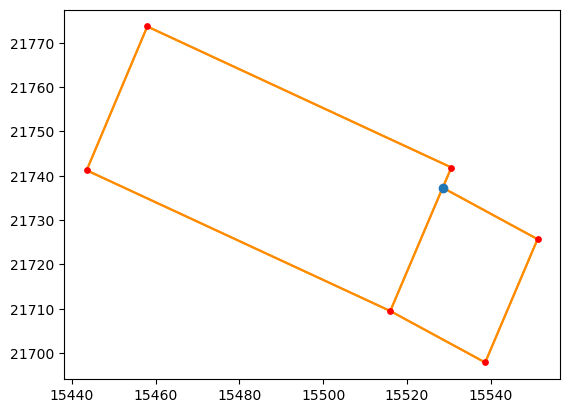

In [11]:
fig, ax = plt.subplots()
plot_image(building, iid1, ax)
ax.scatter(*tr)

0
1
2
3
4
5
6


(22610.0, 22690.0)

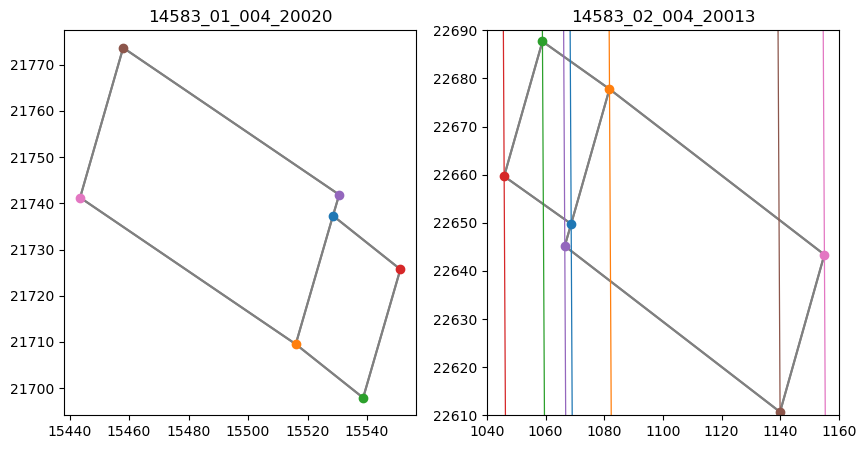

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#n = 2
x1 = np.linspace(15440, 15540, 100)
x2 = np.linspace(50, 1160, 100)

plot_image(building, iid1, axs[0], edge_color='grey')
plot_image(building, iid2, axs[1], edge_color='grey')

for n in range(len(list(building['corners'][iid1]))):
    print(n)
    p1_hom = np.hstack([building['corners'][iid1][n], np.array([1])])
    a, b, c = F@p1_hom
    line = lambda x:  -(a*x + c)/b


    axs[0].scatter(*building['corners'][iid1][n])
    axs[1].scatter(*building['corners'][iid2][n])
    axs[1].plot(x2, line(x2), lw=0.9)
axs[0].set_title(iid1)
axs[1].set_title(iid2)
axs[1].set_xlim(1040, 1160)
axs[1].set_ylim(22610, 22690)

In [133]:
p1_hom = np.hstack([building['corners'][iid1][0], np.array([1])])
a, b, c = F@p1_hom
x1 = np.linspace(15440, 15540, 100)
x2 = np.linspace(1050, 1160, 100)
line = lambda x:  -(a*x + c)/b
a, b, c

(21863.288516452943, 3780507.4117941502, -82401772403.80475)

In [ ]:
def epipolar_line(point)

In [163]:
p1 = np.hstack([np.array(building['corners'][iid1][2]), np.array([1])])
p2 = np.hstack([np.array(building['corners'][iid2][2]), np.array([1])])

In [206]:
p2@ F @ p1

9147.455646514893